# Predicting Religion from Country Flags 

Professor Bengfort put together a [notebook](https://github.com/georgetown-analytics/machine-learning/blob/master/examples/bbengfort/flags/flags.ipynb) using the UCI Machine Learning Repository [_flags_](https://archive.ics.uci.edu/ml/datasets/Flags) dataset to predict the religion of a country based on the attributes of their flags. 

What if we had the same data, without the religion column? Can we used unsupervised machine learning to draw some conclusions about the data?

🇦🇫🇦🇽🇦🇱🇩🇿🇦🇸🇦🇩🇦🇴🇦🇮🇦🇶🇦🇬🇦🇷🇦🇲🇦🇼🇦🇺🇦🇹🇦🇿🇧🇸🇧🇭🇧🇩🇧🇧🇧🇾🇧🇪🇧🇿🇧🇯🇧🇲🇧🇹🇧🇴🇧🇶🇧🇦🇧🇼🇧🇷🇮🇴

Here is some infomation about our dataset:

### Data Set Information:

This data file contains details of various nations and their flags. In this file the fields are separated by spaces (not commas). With this data you can try things like predicting the religion of a country from its size and the colours in its flag. 

10 attributes are numeric-valued. The remainder are either Boolean- or nominal-valued.


### Attribute Information:

1. name:	Name of the country concerned 
2. landmass:	1=N.America, 2=S.America, 3=Europe, 4=Africa, 4=Asia, 6=Oceania 
3. zone:	Geographic quadrant, based on Greenwich and the Equator; 1=NE, 2=SE, 3=SW, 4=NW 
4. area:	in thousands of square km 
5. population:	in round millions 
6. language: 1=English, 2=Spanish, 3=French, 4=German, 5=Slavic, 6=Other Indo-European, 7=Chinese, 8=Arabic, 9=Japanese/Turkish/Finnish/Magyar, 10=Others 
7. religion: 0=Catholic, 1=Other Christian, 2=Muslim, 3=Buddhist, 4=Hindu, 5=Ethnic, 6=Marxist, 7=Others 
8. bars: Number of vertical bars in the flag 
9. stripes: Number of horizontal stripes in the flag 
10. colours: Number of different colours in the flag 
11. red: 0 if red absent, 1 if red present in the flag 
12. green: same for green 
13. blue: same for blue 
14. gold: same for gold (also yellow) 
15. white: same for white 
16. black: same for black 
17. orange: same for orange (also brown) 
18. mainhue: predominant colour in the flag (tie-breaks decided by taking the topmost hue, if that fails then the most central hue, and if that fails the leftmost hue) 
19. circles: Number of circles in the flag 
20. crosses: Number of (upright) crosses 
21. saltires: Number of diagonal crosses 
22. quarters: Number of quartered sections 
23. sunstars: Number of sun or star symbols 
24. crescent: 1 if a crescent moon symbol present, else 0 
25. triangle: 1 if any triangles present, 0 otherwise 
26. icon: 1 if an inanimate image present (e.g., a boat), otherwise 0 
27. animate: 1 if an animate image (e.g., an eagle, a tree, a human hand) present, 0 otherwise 
28. text: 1 if any letters or writing on the flag (e.g., a motto or slogan), 0 otherwise 
29. topleft: colour in the top-left corner (moving right to decide tie-breaks) 
30. botright: Colour in the bottom-left corner (moving left to decide tie-breaks)

In [43]:
import os
import requests

import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt 

from sklearn import manifold
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from time import time

In [44]:
%matplotlib inline
pd.set_option('max_columns', 500)

Let's grab the data and set it up for analysis.

In [45]:


URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/flags/flag.data"

def fetch_data(fname='flags.txt'):
    """
    Helper method to retreive the ML Repository dataset.
    """
    response = requests.get(URL)
    outpath  = os.path.abspath(fname)
    with open(outpath, 'wb') as f:
        f.write(response.content)
    
    return outpath

# Fetch the data if required
DATA = fetch_data()

In [46]:
# Load data and do some simple data management 
# We are going to define the names from the features and build a dictionary to convert our categorical features.

FEATS = [
    "name", "landmass", "zone", "area", "population", "language", "religion", "bars", 
    "stripes", "colours", "red", "green", "blue", "gold", "white", "black", "orange", 
    "mainhue", "circles", "crosses", "saltires", "quarters", "sunstars", "crescent", 
    "triangle", "icon", "animate", "text", "topleft", "botright",
]

COLOR_MAP = {"red": 1, "blue": 2, "green": 3, "white": 4, "gold": 5, "black": 6, "orange": 7, "brown": 8}

# Load Data 
df = pd.read_csv(DATA, header=None, names=FEATS)

df.head()

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,red,green,blue,gold,white,black,orange,mainhue,circles,crosses,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
0,Afghanistan,5,1,648,16,10,2,0,3,5,1,1,0,1,1,1,0,green,0,0,0,0,1,0,0,1,0,0,black,green
1,Albania,3,1,29,3,6,6,0,0,3,1,0,0,1,0,1,0,red,0,0,0,0,1,0,0,0,1,0,red,red
2,Algeria,4,1,2388,20,8,2,2,0,3,1,1,0,0,1,0,0,green,0,0,0,0,1,1,0,0,0,0,green,white
3,American-Samoa,6,3,0,0,1,1,0,0,5,1,0,1,1,1,0,1,blue,0,0,0,0,0,0,1,1,1,0,blue,red
4,Andorra,3,1,0,0,6,0,3,0,3,1,0,1,1,0,0,0,gold,0,0,0,0,0,0,0,0,0,0,blue,red


In [47]:
#df['mainhue'] = df['mainhue'].map(COLOR_MAP)
#df['topleft'] = df['topleft'].map(COLOR_MAP)
#df['botright'] = df['botright'].map(COLOR_MAP)


In [48]:
# Now we will use the dictionary to convert categoricals into int values

for k,v in COLOR_MAP.items():
    df.loc[df.mainhue == k, 'mainhue'] = v
    
for k,v in COLOR_MAP.items():
    df.loc[df.topleft == k, 'topleft'] = v
    
for k,v in COLOR_MAP.items():
    df.loc[df.botright == k, 'botright'] = v
    
df.mainhue = df.mainhue.apply(int)
df.topleft = df.topleft.apply(int)
df.botright = df.botright.apply(int)

In [49]:
df.head()

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,red,green,blue,gold,white,black,orange,mainhue,circles,crosses,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
0,Afghanistan,5,1,648,16,10,2,0,3,5,1,1,0,1,1,1,0,3,0,0,0,0,1,0,0,1,0,0,6,3
1,Albania,3,1,29,3,6,6,0,0,3,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,1
2,Algeria,4,1,2388,20,8,2,2,0,3,1,1,0,0,1,0,0,3,0,0,0,0,1,1,0,0,0,0,3,4
3,American-Samoa,6,3,0,0,1,1,0,0,5,1,0,1,1,1,0,1,2,0,0,0,0,0,0,1,1,1,0,2,1
4,Andorra,3,1,0,0,6,0,3,0,3,1,0,1,1,0,0,0,5,0,0,0,0,0,0,0,0,0,0,2,1


In [50]:
df.describe()

,landmass,zone,area,population,language,religion,bars,stripes,colours,red,green,blue,gold,white,black,orange,mainhue,circles,crosses,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,3.572165,2.211340,700.046392,23.268041,5.340206,2.190722,0.453608,1.551546,3.463918,0.788660,0.469072,0.510309,0.469072,0.752577,0.268041,0.134021,2.582474,0.170103,0.149485,0.092784,0.149485,1.386598,0.056701,0.139175,0.252577,0.201031,0.082474,2.742268,2.438144
std,1.553018,1.308274,2170.927932,91.934085,3.496517,2.061167,1.038339,2.328005,1.300154,0.409315,0.500334,0.501187,0.500334,0.432631,0.444085,0.341556,1.683785,0.463075,0.385387,0.290879,0.435860,4.396186,0.231869,0.347025,0.435615,0.401808,0.275798,1.595189,1.546780
min,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,3.000000,1.000000,9.000000,0.000000,2.000000,1.000000,0.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,4.000000,2.000000,111.000000,4.000000,6.000000,1.000000,0.000000,0.000000,3.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000
75%,5.000000,4.000000,471.250000,14.000000,9.000000,4.000000,0.000000,3.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.750000,0.000000,0.000000,4.000000,3.000000
max,6.000000,4.000000,22402.000000,1008.000000,10.000000,7.000000,5.000000,14.000000,8.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8.000000,4.000000,2.000000,1.000000,4.000000,50.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,8.000000


## Clustering

Clustering is an unsupervised machine learning method. This means we don't have to have a value we are predicting. 

You can use clustering when you know this information as well. Scikit-learn provides a number of metrics you can employ with a "known ground truth" (i.e. the values you are predicting). We won't cover them here, but you can use this notebook to add some cells, create your "y" value, and explore the metrics described [here](http://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation).

In the case of the flags data, we do have our "known ground truth". However, for the purpose of this exercise we are going to drop that information out of our data set. We will use it later with Agglomerative Clustering.

In [51]:
feature_names = [
    "landmass", "zone", "area", "population", "language", "bars", 
    "stripes", "colours", "red", "green", "blue", "gold", "white", "black", "orange", 
    "mainhue", "circles", "crosses", "saltires", "quarters", "sunstars", "crescent", 
    "triangle", "icon", "animate", "text", "topleft", "botright",
]

X = df[feature_names]
y = df.religion

## KMeans Clustering

Let's look at KMeans clustering first.

"K-means is a simple unsupervised machine learning algorithm that groups a dataset into a user-specified number (k) of clusters. The algorithm is somewhat naive--it clusters the data into k clusters, even if k is not the right number of clusters to use. Therefore, when using k-means clustering, users need some way to determine whether they are using the right number of clusters."

One way to determine the number of cluster is through the "elbow" method. Using this method, we try a range of values for k and evaluate the ["variance explained as a function of the number of clusters"](https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_Elbow_Method).

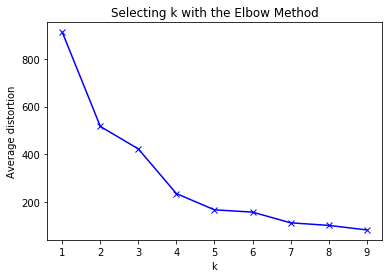

In [52]:
# Code adapted from https://www.packtpub.com/books/content/clustering-k-means
K = range(1,10)
meandistortions = []

for k in K:

    elbow = KMeans(n_clusters=k, n_jobs=-1, random_state=1)
    elbow.fit(X)
    meandistortions.append(sum(np.min(euclidean_distances(X, elbow.cluster_centers_), axis=1)) / X.shape[0])

    
plt.plot(K, meandistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')
plt.show()

If the line chart looks like an arm, then the "elbow" on the arm is the value of k that is the best. Our goal is to choose a small value of k that still has a low variance. The elbow usually represents where we start to have diminishing returns by increasing k.
    
However, the elbow method doesn't always work well; especially if the data is not very clustered. 

Based on our plot, it looks like k=4 and k=5 are worth looking at. How do we measure which might be better? We can use the Silhouette Coefficient. A higher Silhouette Coefficient score relates to a model with better defined clusters.

In [53]:
kmeans = KMeans(n_clusters=5, n_jobs=-1, random_state=1)
kmeans.fit(X)
labels = kmeans.labels_
silhouette_score(X, labels, metric='euclidean')

0.7429313306419209

In [54]:
kmeans = KMeans(n_clusters=4, n_jobs=-1, random_state=1)
kmeans.fit(X)
labels = kmeans.labels_
silhouette_score(X, labels, metric='euclidean')

0.7797789282635552

We can see above, k=4 has a better score.

As implemented in scikit-learn, [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) will use 8 clusters by default. Given our data, it makes sense to try this out since our data actually has 8 potential labels (look at "religion" in the data secription above). Based on the plot above, we should expect the silhouette score for k=8 to be less than for k=4.

In [55]:
kmeans = KMeans(n_clusters=8, n_jobs=-1, random_state=1)
kmeans.fit(X)
labels = kmeans.labels_
silhouette_score(X, labels, metric='euclidean')

0.6661256453981661

We can also visualize what our clusters look like. The function below will plot the clusters and visulaize their silhouette scores.

In [56]:
# Code adapted from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

def silhouette_plot(X, range_n_clusters = range(2, 12, 2)):

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1
        ax1.set_xlim([-.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

For n_clusters = 2 The average silhouette_score is : 0.9360366603556858


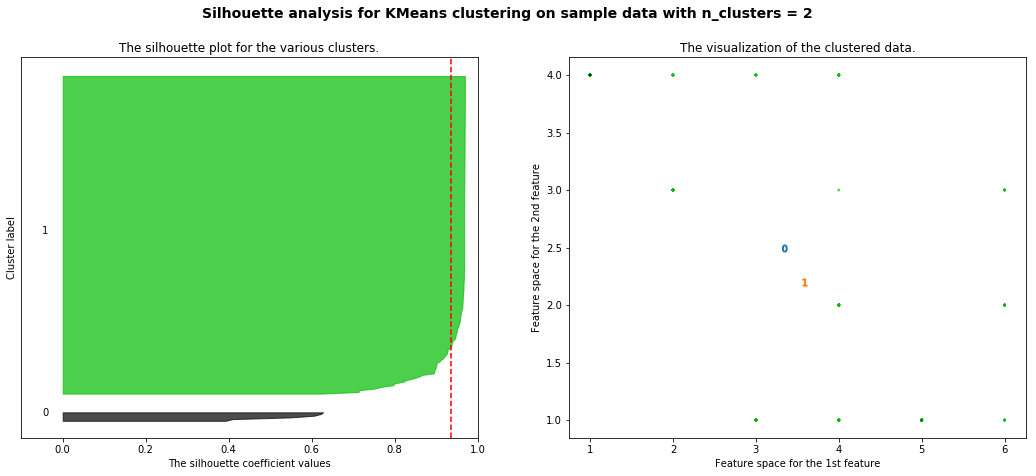

For n_clusters = 4 The average silhouette_score is : 0.7797789282635552


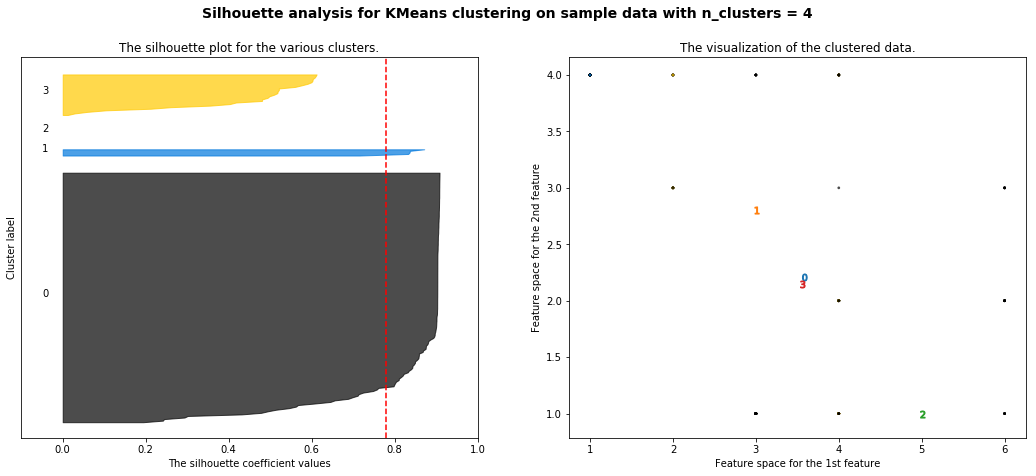

For n_clusters = 6 The average silhouette_score is : 0.6736174401783215


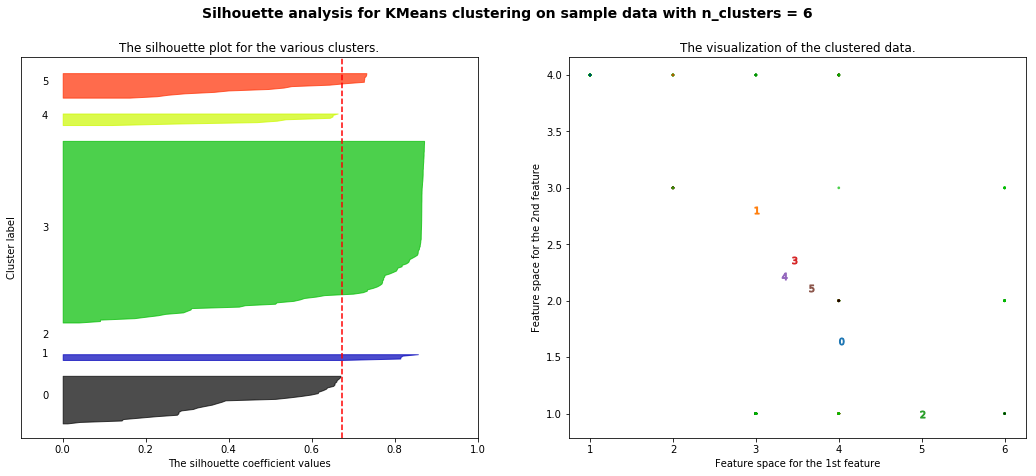

For n_clusters = 8 The average silhouette_score is : 0.6661256453981661


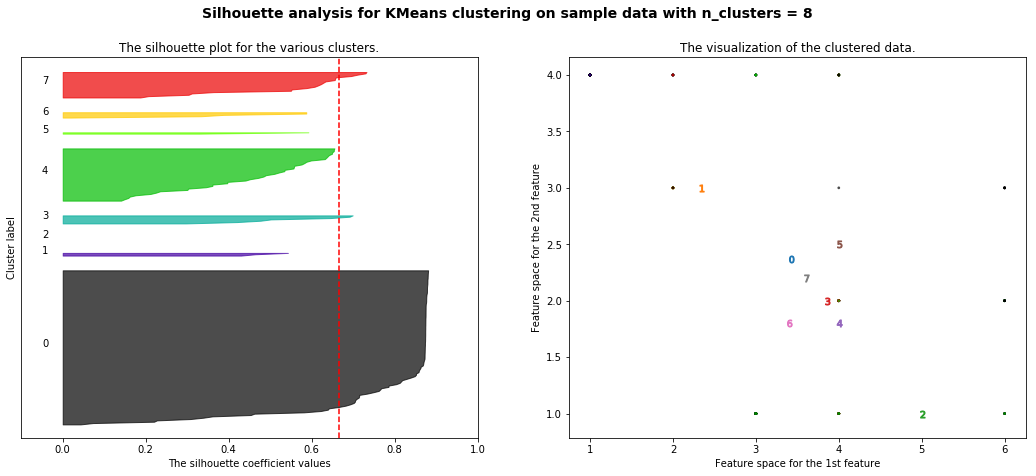

For n_clusters = 10 The average silhouette_score is : 0.6634663205312777


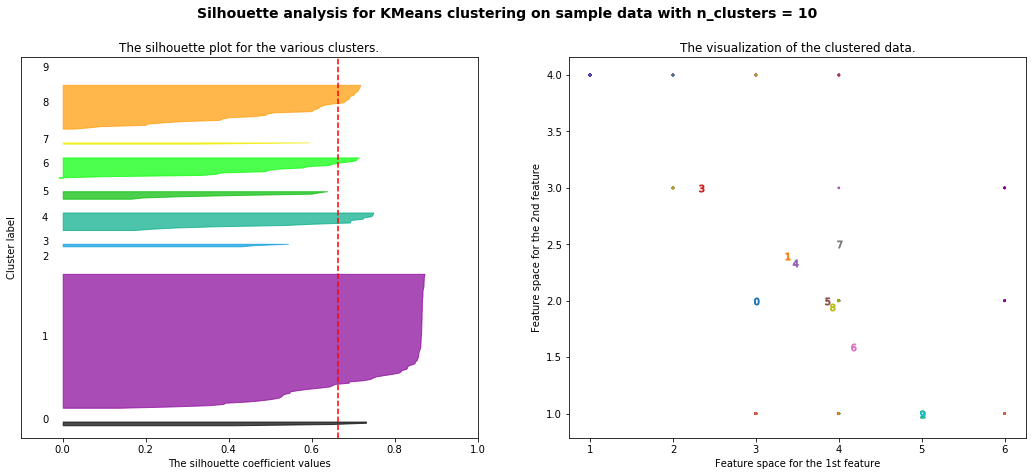

In [57]:
silhouette_plot(X)

If we had just used silhouette scores, we would have missed that a lot of our data is actually not clustering very well. The plots above should make us reevaluate whether clustering is the right thing to do on our data.

## Hierarchical clustering

Hierarchical clustering is a general family of clustering algorithms that build nested clusters by merging or splitting them successively. This hierarchy of clusters is represented as a tree (or dendrogram). The root of the tree is the unique cluster that gathers all the samples, the leaves being the clusters with only one sample. See the [Wikipedia page](https://en.wikipedia.org/wiki/Hierarchical_clustering) for more details.

## Agglomerative Clustering

The [AgglomerativeClustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)  object performs a hierarchical clustering using a bottom up approach: each observation starts in its own cluster, and clusters are successively merged together. 

The linkage criteria determines the metric used for the merge strategy:
* Ward minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.
* Maximum or complete linkage minimizes the maximum distance between observations of pairs of clusters.
* Average linkage minimizes the average of the distances between all observations of pairs of clusters.

AgglomerativeClustering can also scale to large number of samples when it is used jointly with a connectivity matrix, but is computationally expensive when no connectivity constraints are added between samples: it considers at each step all the possible merges.

In [58]:
# Code adapted from http://scikit-learn.org/stable/auto_examples/cluster/plot_digits_linkage.html

# Visualize the clustering
def plot_clustering(X_red, X, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(y[i]),
                 color=plt.cm.nipy_spectral(labels[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout()

Computing embedding
Done.
ward : 0.00s
average : 0.00s
complete : 0.00s


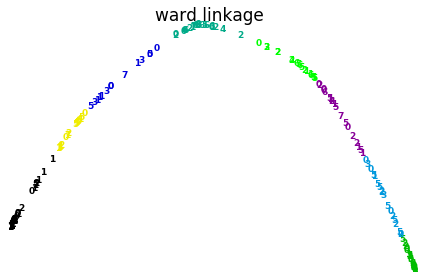

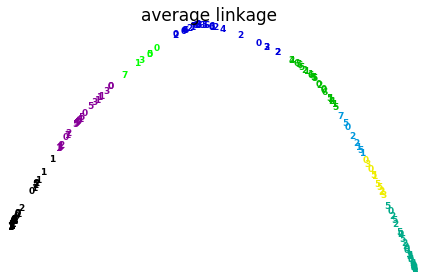

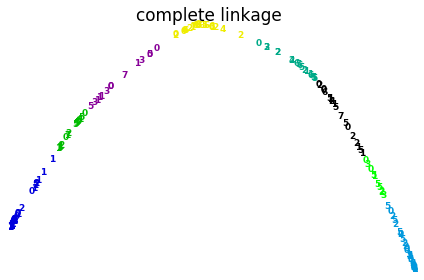

In [59]:
print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
print("Done.")

for linkage in ('ward', 'average', 'complete'):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=8)
    t0 = time()
    clustering.fit(X_red)
    print("%s : %.2fs" % (linkage, time() - t0))

    plot_clustering(X_red, X, clustering.labels_, "%s linkage" % linkage)


plt.show()

This notebook has been compiled using several references:

* [Clustering with K-Means](https://www.packtpub.com/books/content/clustering-k-means)
* [Selecting the number of clusters with silhouette analysis on KMeans clustering](
http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)
* [Using the elbow method to determine the optimal number of clusters for k-means clustering](https://bl.ocks.org/rpgove/0060ff3b656618e9136b)
* [Clustering performance evaluation](http://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation)
* [Hierarchical clustering](http://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering)
* [Various Agglomerative Clustering on a 2D embedding of digits](http://scikit-learn.org/stable/auto_examples/cluster/plot_digits_linkage.html#sphx-glr-auto-examples-cluster-plot-digits-linkage-py)